In [1]:
%load_ext autoreload
%autoreload 2

import pickle

# Scraping
import bs4
import nltk
import requests
from bs4 import BeautifulSoup
from langdetect import detect

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Clustering
import numpy as np
import gensim.corpora as corpora
from scipy.spatial.distance import pdist
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# Visualization
from bokeh.io import output_notebook

output_notebook()

from helpers import *

[nltk_data] Downloading package punkt to /home/thomas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/thomas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/thomas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/thomas/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Loading BokehJS ...

# Document Extraction

I chose to scrape recipes in English, French and Spanish. Since I could not find a multilingual recipe website, I scrape a different website for each language. For each recipe, three sections are scraped:
- the recipe's title
- the list of ingredients
- the directions to make the recipe

In [2]:
RECIPES_PER_LANGUAGE = 50

## Recipes in English (Allrecipes)

In [3]:
site_request = requests.get("https://allrecipes.com/recipes")
soup = BeautifulSoup(site_request.text, "html.parser")

In [4]:
links = soup.find_all('a')
recipe_links = [link for link in links if
                link.has_key("href") and link['href'].startswith(
                    "https://www.allrecipes.com/recipe/")]  # only keep links which are actually recipes

In [5]:
recipe_text = {"title": [], "ingredients": [], "directions": []}

for i in range(RECIPES_PER_LANGUAGE):
    print(i, recipe_links[i]["href"])
    recipe_request = requests.get(recipe_links[i]["href"])
    recipe_soup = BeautifulSoup(recipe_request.text, "html.parser")

    # extract title
    title = recipe_soup.find("h1", {"id": "article-heading_2-0"})
    recipe_text["title"].append(title.contents[0][1:])

    # extract ingredient list
    ingredients = recipe_soup.find_all("li", {"class": "mntl-structured-ingredients__list-item"})
    ingredients = [ingredient.findChildren("span", recursive=True) for ingredient in ingredients]
    ingredients = [" ".join([ingr.contents[0] if ingr.contents else "" for ingr in ingredient]) for ingredient in
                   ingredients]
    recipe_text["ingredients"].append(ingredients)

    # extract list of directions
    directions = recipe_soup.find_all("li",
                                      {"class": "comp mntl-sc-block-group--LI mntl-sc-block mntl-sc-block-startgroup"})
    directions = [direction.findChildren("p")[0].contents[0][1:-1] for direction in directions]
    recipe_text["directions"].append(directions)

0 https://www.allrecipes.com/recipe/268796/spicy-gluten-free-chicken-and-cheddar-waffles-with-blackberry-maple-syrup/
1 https://www.allrecipes.com/recipe/269881/saucy-sriracha-franks/
2 https://www.allrecipes.com/recipe/275252/grilled-halloumi-with-herbed-berry-salsa/
3 https://www.allrecipes.com/recipe/267120/vegan-pumpkin-pancakes/
4 https://www.allrecipes.com/recipe/279625/pb-j-smoothie/
5 https://www.allrecipes.com/recipe/151593/campbells-tuna-noodle-casserole/
6 https://www.allrecipes.com/recipe/6874/best-ever-muffins/
7 https://www.allrecipes.com/recipe/35151/traditional-filipino-lumpia/
8 https://www.allrecipes.com/recipe/47015/quick-and-easy-pancit/
9 https://www.allrecipes.com/recipe/9889/seven-layer-bars/
10 https://www.allrecipes.com/recipe/11991/egg-noodles/
11 https://www.allrecipes.com/recipe/240641/salt-dough/
12 https://www.allrecipes.com/recipe/240522/easy-rib-eye-roast/
13 https://www.allrecipes.com/recipe/46982/pesto-pasta-with-chicken/
14 https://www.allrecipes.com/

In [6]:
df_recipes_en = pd.DataFrame.from_dict(recipe_text)
df_recipes_en.head()

,title,ingredients,directions
0,Spicy Gluten-Free Chicken and Cheddar Waffles ...,"[4 fresh blackberries, 1 teaspoon ancho chile...",[Muddle 4 blackberries in the bottom of a micr...
1,Saucy Sriracha Franks,"[1 cup ketchup, ¼ cup soy sauce, ¼ cup rice vi...","[Mix ketchup, soy sauce, vinegar, sriracha, br..."
2,Grilled Halloumi with Herbed Berry Salsa,"[4 ounces fresh blueberries, 3 ounces red curr...",[Place blueberries and red currants into a mix...
3,Vegan Pumpkin Pancakes,"[2 cups almond milk, 2 tablespoons distilled w...",[Combine almond milk and vinegar together in a...
4,PB & J Smoothie,"[6 frozen strawberries, or more to taste, ¾ c...","[Combine strawberries, milk, peanut butter, bl..."


## Recipes in French (Marmiton)

In [7]:
site_request = requests.get("https://www.marmiton.org/recettes/top-internautes.aspx")
soup = BeautifulSoup(site_request.text, "html.parser")

In [8]:
recipe_links = soup.find_all('a', {"class": "recipe-card-link"})

In [9]:
recipe_text = {"title": [], "ingredients": [], "directions": []}

for i in range(RECIPES_PER_LANGUAGE):
    print(i, recipe_links[i]["href"])
    recipe_request = requests.get(recipe_links[i]["href"])
    recipe_soup = BeautifulSoup(recipe_request.text, "html.parser")

    # extract title
    title = recipe_soup.find("h1", {"class": "SHRD__sc-10plygc-0 itJBWW"})
    recipe_text["title"].append(
        str(title.contents[0].string))  # NavigableStrings need to be converted to regular strings to be able to pickle

    # extract ingredients
    ingredients = recipe_soup.find_all("span", {"class": "SHRD__sc-10plygc-0 kWuxfa"})
    ingredients = [ingredient.findChildren("span", recursive=True) for ingredient in ingredients]
    ingredients = [
        " ".join([str(ingr.contents[0].string) if ingr.contents and len(ingr.contents) == 1 else "" for ingr in
                  ingredient]).strip()
        for ingredient in ingredients]
    recipe_text["ingredients"].append(ingredients)

    # extract directions
    directions = recipe_soup.find_all("p", {"class": "RCP__sc-1wtzf9a-3 jFIVDw"})
    directions = [str(direction.contents[0].string) for direction in directions]
    recipe_text["directions"].append(directions)

0 https://www.marmiton.org/recettes/recette_blanquette-de-veau-facile_19219.aspx
1 https://www.marmiton.org/recettes/recette_tiramisu-recette-originale_12023.aspx
2 https://www.marmiton.org/recettes/recette_lasagnes-a-la-bolognaise_18215.aspx
3 https://www.marmiton.org/recettes/recette_la-vraie-moussaka-grecque_72593.aspx
4 https://www.marmiton.org/recettes/recette_meringue-pour-les-nuls_36610.aspx
5 https://www.marmiton.org/recettes/recette_pancakes_15299.aspx
6 https://www.marmiton.org/recettes/recette_filet-mignon-en-croute_14407.aspx
7 https://www.marmiton.org/recettes/recette_ramequins-fondants-au-chocolat_15816.aspx
8 https://www.marmiton.org/recettes/recette_le-crumble-aux-pommes-du-chat-qui-tousse_10534.aspx
9 https://www.marmiton.org/recettes/recette_bechamel-rapide-et-facile_14764.aspx
10 https://www.marmiton.org/recettes/recette_original-american-cookies-de-mike_39907.aspx
11 https://www.marmiton.org/recettes/recette_les-timbales-de-jeanne-saumon-a-la-mousse-de-courgettes-au

In [10]:
df_recipes_fr = pd.DataFrame.from_dict(recipe_text)
df_recipes_fr.head()

,title,ingredients,directions
0,Blanquette de veau : recette traditionnelle,"[cube de bouillon de légumes, carottes, oignon...",[Faire revenir la viande dans un peu de beurre...
1,Tiramisu (recette originale),"[de sucre roux, de sucre vanillé, biscuits à...","[Séparer les blancs des jaunes d'oeufs., Mélan..."
2,Lasagnes à la bolognaise,"[de lasagnes, oignons jaunes, d' ail, de cél...",[Faire revenir gousses hachées d'ail et les oi...
3,La Vraie Moussaka Grecque,"[de beurre, de farine, de lait, aubergines,...",[Préparation de la sauce tomate.\nEmincer les ...
4,Meringue : recette facile,"[de sucre semoule, blancs d'oeuf]",[Quelques trucs pour bien réussir ces meringue...


## Recipes in Spanish (Comedera)

In [11]:
site_request = requests.get("https://www.comedera.com/100-platos-comida-espanola/")
soup = BeautifulSoup(site_request.text, "html.parser")

In [12]:
recipe_links = soup.find_all('h3')
recipe_links = [r.contents[1] for r in recipe_links if r.find("a")][:-1]
del recipe_links[42]  # one of the recipes has a different html structure, so ignore it for simplicity

In [13]:
recipe_text = {"title": [], "ingredients": [], "directions": []}
for i in range(RECIPES_PER_LANGUAGE):
    print(i, recipe_links[i]["href"])
    recipe_request = requests.get(recipe_links[i]["href"])
    recipe_soup = BeautifulSoup(recipe_request.text, "html.parser")

    # extract recipe title
    title = str(recipe_links[i].contents[0].string)
    recipe_text["title"].append(title)

    # extract recipe ingredients
    ingredients = recipe_soup.find_all("li", {"class": "wprm-recipe-ingredient"})
    ingredients = [ingredient.findChildren("span") for ingredient in ingredients]
    ingredients = [" ".join([ingr.contents[0] if ingr.contents else "" for ingr in ingredient]) for ingredient in
                   ingredients]
    recipe_text["ingredients"].append(ingredients)

    # extract recipe directions
    directions = recipe_soup.find_all("div", {"class": "wprm-recipe-instruction-text"})
    directions = [direction.contents[0] for direction in directions]
    directions = [str(direction.contents[0].string) if type(direction) is bs4.element.Tag else str(direction.string) for
                  direction in directions]  # some directions are already strings and others are Spans
    recipe_text["directions"].append(directions)

0 https://www.comedera.com/receta-huevos-rotos/
1 https://www.comedera.com/cachopo-asturiano/
2 https://www.comedera.com/receta-calamares-en-su-tinta/
3 https://www.comedera.com/como-hacer-tortilla-de-patatas-perfecta/
4 https://www.comedera.com/como-hacer-migas/
5 https://www.comedera.com/receta-de-arroz-negro/
6 https://www.comedera.com/pimientos-de-piquillo-rellenos-de-bacalao/
7 https://www.comedera.com/arroz-caldoso-con-pollo/
8 https://www.comedera.com/receta-cocido-madrileno/
9 https://www.comedera.com/receta-patatas-revolconas/
10 https://www.comedera.com/receta-gambas-al-ajillo/
11 https://www.comedera.com/como-hacer-patatas-bravas/
12 https://www.comedera.com/receta-para-hacer-bacalao-la-vizcaina/
13 https://www.comedera.com/como-hacer-fideua-de-mariscos/
14 https://www.comedera.com/receta-chorizo-a-la-sidra/
15 https://www.comedera.com/receta-bacalao-al-pil-pil/
16 https://www.comedera.com/como-hacer-paella-valenciana/
17 https://www.comedera.com/cochinillo-al-horno/
18 http

In [14]:
df_recipes_sp = pd.DataFrame.from_dict(recipe_text)
df_recipes_sp.head()

,title,ingredients,directions
0,Huevos rotos,"[2 huevos grandes, 2 patatas medianas, 1 chori...",[Quítale la piel y corta las patatas de la for...
1,Cachopo,"[2 filetes de ternera alargados, de alrededor ...","[Para empezar, lo ideal es que los filetes de ..."
2,Chipirones en su tinta,"[Calamar picado en forma de anillos: 1 kilo., ...","[Si los calamares no están limpios, pues a lim..."
3,Tortilla de patatas,"[500 gr de patatas sin pelar, 5 huevos, 1 cebo...",[Pela las patatas y pícalas en rodajas o gajos...
4,Migas del pastor,"[1 barra de pan duro del día anterior, 6 dient...",[Corta el pan en cubos pequeños y ponlo en un ...


In [15]:
pickle.dump(df_recipes_en, open("df_recipes_en.pkl", "wb"))
pickle.dump(df_recipes_fr, open("df_recipes_fr.pkl", "wb"))
pickle.dump(df_recipes_sp, open("df_recipes_sp.pkl", "wb"))

# Language Detection

Each recipe's language is detected by using langdetect on the recipe's directions. Using the directions is more robust since it has the largest size and the title and ingredients sometimes contain foreign words.

I then chose to translate each recipe to English using googletrans. This has the downside of taking a bit of time, although not too much (~3 minutes for 150 recipes) since the recipes are often quite short. But it then greatly simplifies the preprocessing of the text and allows us to cluster all the documents at the same time without having to treat each language case by case.

In [16]:
df_recipes_en = pickle.load(open("df_recipes_en.pkl", "rb"))
df_recipes_fr = pickle.load(open("df_recipes_fr.pkl", "rb"))
df_recipes_sp = pickle.load(open("df_recipes_sp.pkl", "rb"))

In [17]:
# store all recipes in a single dataframe
df_recipes = pd.concat([df_recipes_en, df_recipes_fr, df_recipes_sp], ignore_index=True)

In [18]:
detected_languages = []
for directions in df_recipes["directions"].str.join(" "):  # use the directions section to detect the language
    detected_languages.append(detect(directions))

In [19]:
df_recipes["language"] = detected_languages

In [20]:
df_recipes.language.value_counts()

en    50
fr    50
es    50
Name: language, dtype: int64

In [21]:
MAX_TRANS_LEN = 5000  # googletrans only accepts texts of length up to 5000

# lists to store translated sections
translated_title = []
translated_ingredients = []
translated_directions = []

for _, recipe in df_recipes.iterrows():
    if recipe["language"] != "en":  # only translate non-english text
        # translate title
        translate_chunk(recipe["title"], translated_title, recipe["language"])

        # translate list of ingredients
        joined_ingredients = ", ".join(recipe["ingredients"])
        translate_chunk(joined_ingredients, translated_ingredients, recipe["language"])

        # translate list of directions
        joined_directions = ". ".join(recipe["directions"])
        if len(joined_directions) <= MAX_TRANS_LEN:
            translate_chunk(joined_directions, translated_directions, recipe["language"])
        else:
            translated = []
            for i in range((
                                   len(joined_directions) // MAX_TRANS_LEN) + 1):  # break up text into chunks of length 5000 and translate one by one
                translate_chunk(joined_directions[MAX_TRANS_LEN * i:MAX_TRANS_LEN * (i + 1)], translated,
                                recipe["language"])
            translated_directions.append(''.join(translated))
    else:
        translated_title.append(recipe["title"])
        translated_ingredients.append(", ".join(recipe["ingredients"]))
        translated_directions.append(". ".join(recipe["directions"]))

df_recipes["translated_title"] = translated_title
df_recipes["translated_ingredients"] = translated_ingredients
df_recipes["translated_directions"] = translated_directions

In [22]:
df_recipes.head()

,title,ingredients,directions,language,translated_title,translated_ingredients,translated_directions
0,Spicy Gluten-Free Chicken and Cheddar Waffles ...,"[4 fresh blackberries, 1 teaspoon ancho chile...",[Muddle 4 blackberries in the bottom of a micr...,en,Spicy Gluten-Free Chicken and Cheddar Waffles ...,"4 fresh blackberries, 1 teaspoon ancho chile ...",Muddle 4 blackberries in the bottom of a micro...
1,Saucy Sriracha Franks,"[1 cup ketchup, ¼ cup soy sauce, ¼ cup rice vi...","[Mix ketchup, soy sauce, vinegar, sriracha, br...",en,Saucy Sriracha Franks,"1 cup ketchup, ¼ cup soy sauce, ¼ cup rice vin...","Mix ketchup, soy sauce, vinegar, sriracha, bro..."
2,Grilled Halloumi with Herbed Berry Salsa,"[4 ounces fresh blueberries, 3 ounces red curr...",[Place blueberries and red currants into a mix...,en,Grilled Halloumi with Herbed Berry Salsa,"4 ounces fresh blueberries, 3 ounces red curra...",Place blueberries and red currants into a mixi...
3,Vegan Pumpkin Pancakes,"[2 cups almond milk, 2 tablespoons distilled w...",[Combine almond milk and vinegar together in a...,en,Vegan Pumpkin Pancakes,"2 cups almond milk, 2 tablespoons distilled wh...",Combine almond milk and vinegar together in a ...
4,PB & J Smoothie,"[6 frozen strawberries, or more to taste, ¾ c...","[Combine strawberries, milk, peanut butter, bl...",en,PB & J Smoothie,"6 frozen strawberries, or more to taste, ¾ cu...","Combine strawberries, milk, peanut butter, blu..."


In [23]:
pickle.dump(df_recipes, open("df_recipes.pkl", "wb"))

# Text Processing

Each section of the recipe (plus a section containing all the others) is preprocessed following these steps:
- Case folding
- Punctuation removal
- Tokenization
- Lemmatization
- Removal of single-character tokens
- Removal of numbers
- Removal of stopwords and too frequent/unfrequent words
- Creation of bigrams (optional)

I then visualize the results with word clouds of each section.

In [24]:
df_recipes = pickle.load(open("df_recipes.pkl", "rb"))

In [25]:
df_recipes["translated_text"] = df_recipes["translated_title"] + ". " + df_recipes["translated_ingredients"] + ". " + df_recipes["translated_directions"]

In [26]:
df_recipes.head()

,title,ingredients,directions,language,translated_title,translated_ingredients,translated_directions,translated_text
0,Spicy Gluten-Free Chicken and Cheddar Waffles ...,"[4 fresh blackberries, 1 teaspoon ancho chile...",[Muddle 4 blackberries in the bottom of a micr...,en,Spicy Gluten-Free Chicken and Cheddar Waffles ...,"4 fresh blackberries, 1 teaspoon ancho chile ...",Muddle 4 blackberries in the bottom of a micro...,Spicy Gluten-Free Chicken and Cheddar Waffles ...
1,Saucy Sriracha Franks,"[1 cup ketchup, ¼ cup soy sauce, ¼ cup rice vi...","[Mix ketchup, soy sauce, vinegar, sriracha, br...",en,Saucy Sriracha Franks,"1 cup ketchup, ¼ cup soy sauce, ¼ cup rice vin...","Mix ketchup, soy sauce, vinegar, sriracha, bro...","Saucy Sriracha Franks. 1 cup ketchup, ¼ cup so..."
2,Grilled Halloumi with Herbed Berry Salsa,"[4 ounces fresh blueberries, 3 ounces red curr...",[Place blueberries and red currants into a mix...,en,Grilled Halloumi with Herbed Berry Salsa,"4 ounces fresh blueberries, 3 ounces red curra...",Place blueberries and red currants into a mixi...,Grilled Halloumi with Herbed Berry Salsa. 4 ou...
3,Vegan Pumpkin Pancakes,"[2 cups almond milk, 2 tablespoons distilled w...",[Combine almond milk and vinegar together in a...,en,Vegan Pumpkin Pancakes,"2 cups almond milk, 2 tablespoons distilled wh...",Combine almond milk and vinegar together in a ...,"Vegan Pumpkin Pancakes. 2 cups almond milk, 2 ..."
4,PB & J Smoothie,"[6 frozen strawberries, or more to taste, ¾ c...","[Combine strawberries, milk, peanut butter, bl...",en,PB & J Smoothie,"6 frozen strawberries, or more to taste, ¾ cu...","Combine strawberries, milk, peanut butter, blu...","PB & J Smoothie. 6 frozen strawberries, or mo..."


In [27]:
preprocess_section(SECTIONS[0], df_recipes, freq_thresh_upper=1, freq_thresh_lower=0)
for section in SECTIONS[1:]:
    preprocess_section(section, df_recipes)

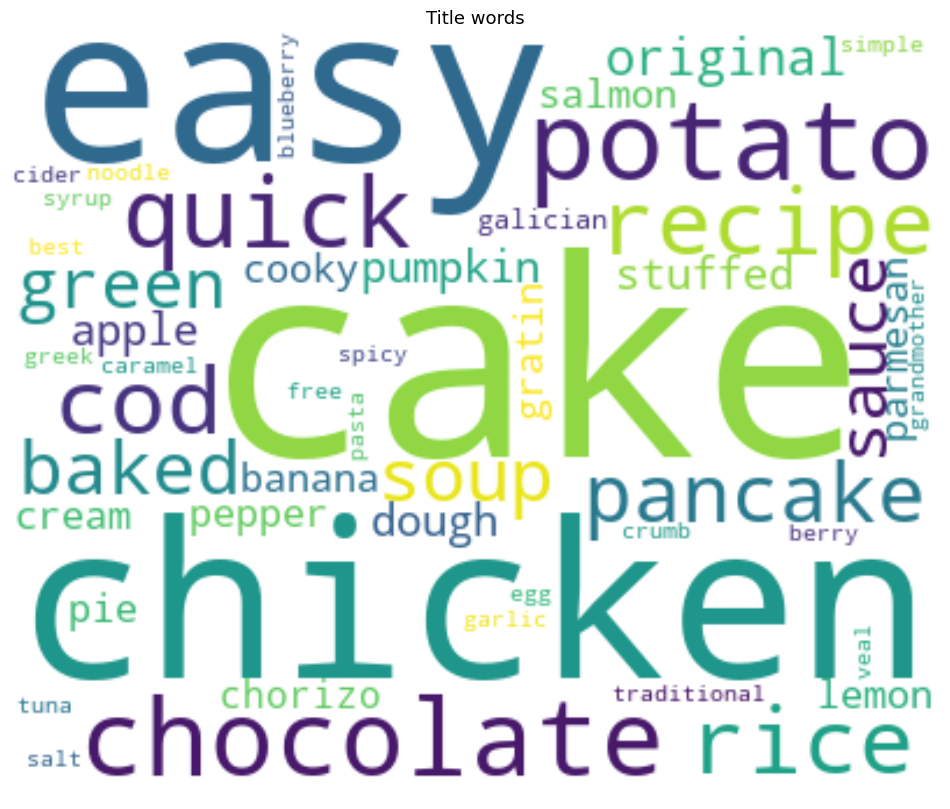

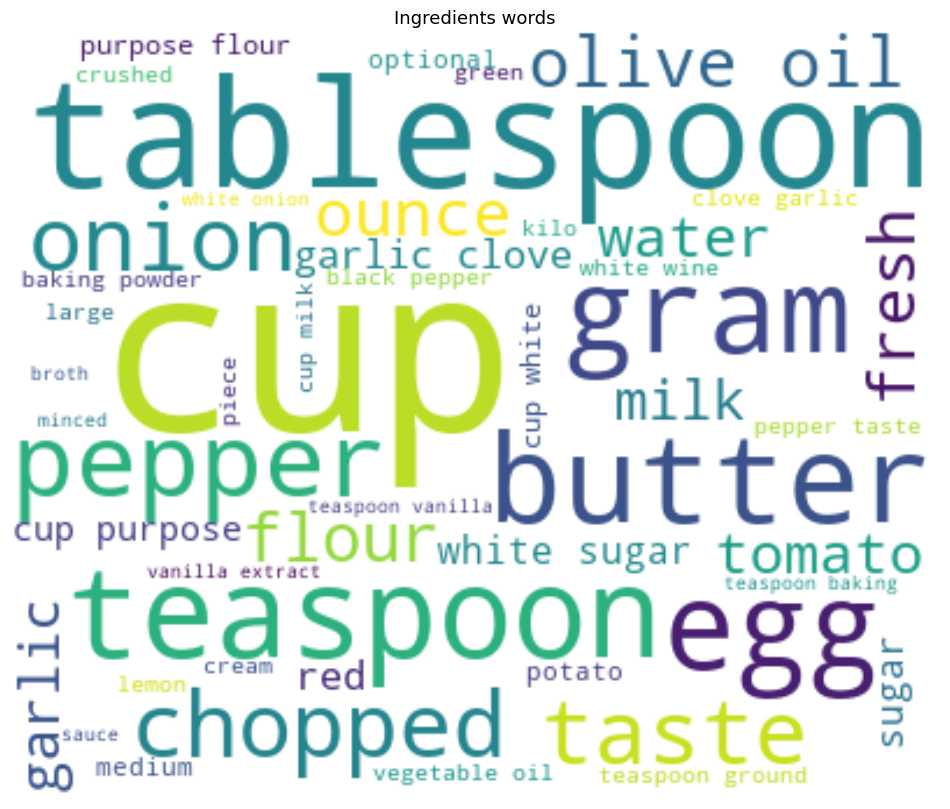

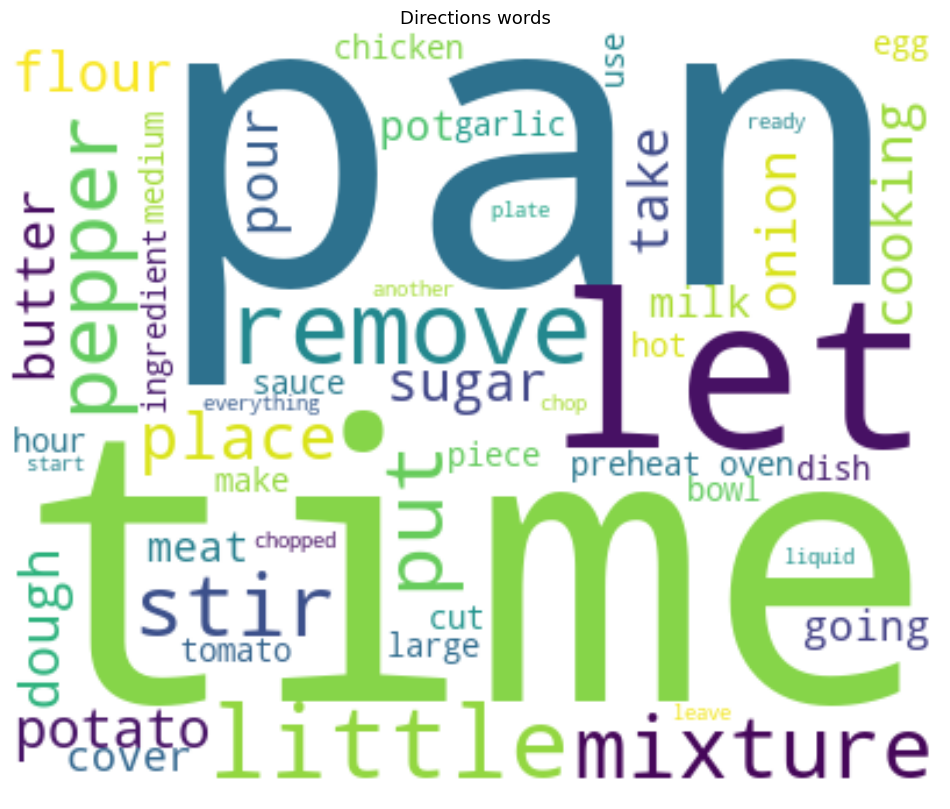

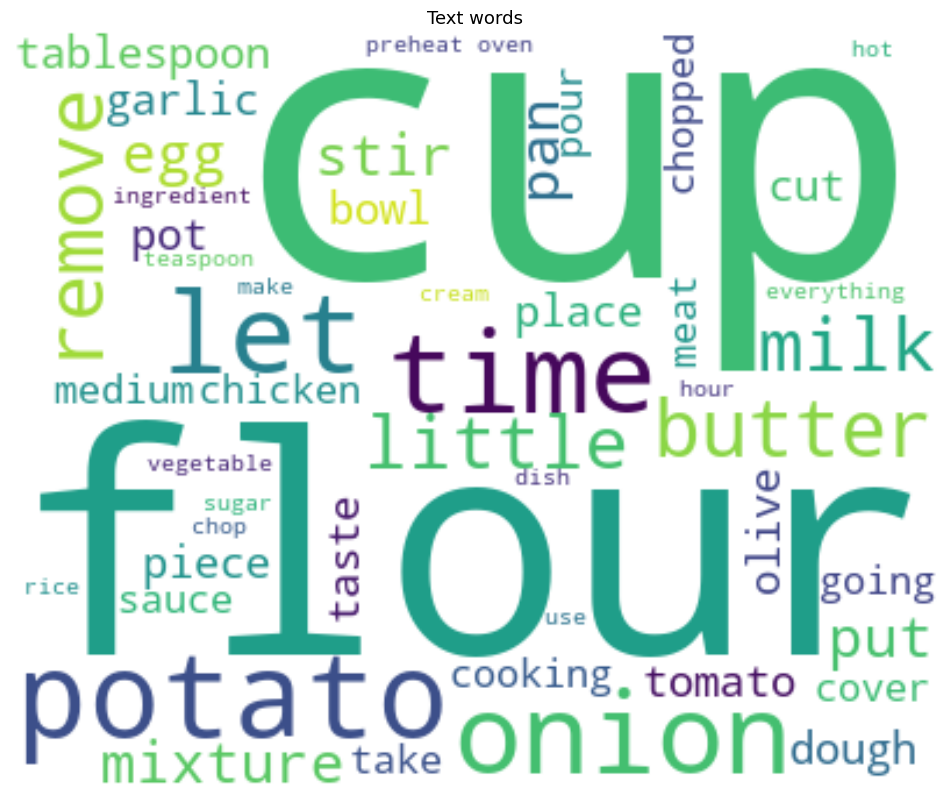

In [28]:
for s in SECTIONS:
    generate_wordcloud(" ".join(list(df_recipes[f'preprocessed_{s}'])), f"{s.capitalize()} words")

In [29]:
pickle.dump(df_recipes, open("df_recipes_clean.pkl", "wb"))

# Cluster documents into logical groups

To vectorize the preprocessed text, I use TF-IDF. I also tried loading word vectors for fasttext, but my laptop doesn't have enough RAM to handle them :(.

In [30]:
df_recipes = pickle.load(open("df_recipes_clean.pkl", "rb"))

## TF-IDF projection

To gain insight into the structure of the data, I project it down to 2 dimensions using PCA and plot the result.

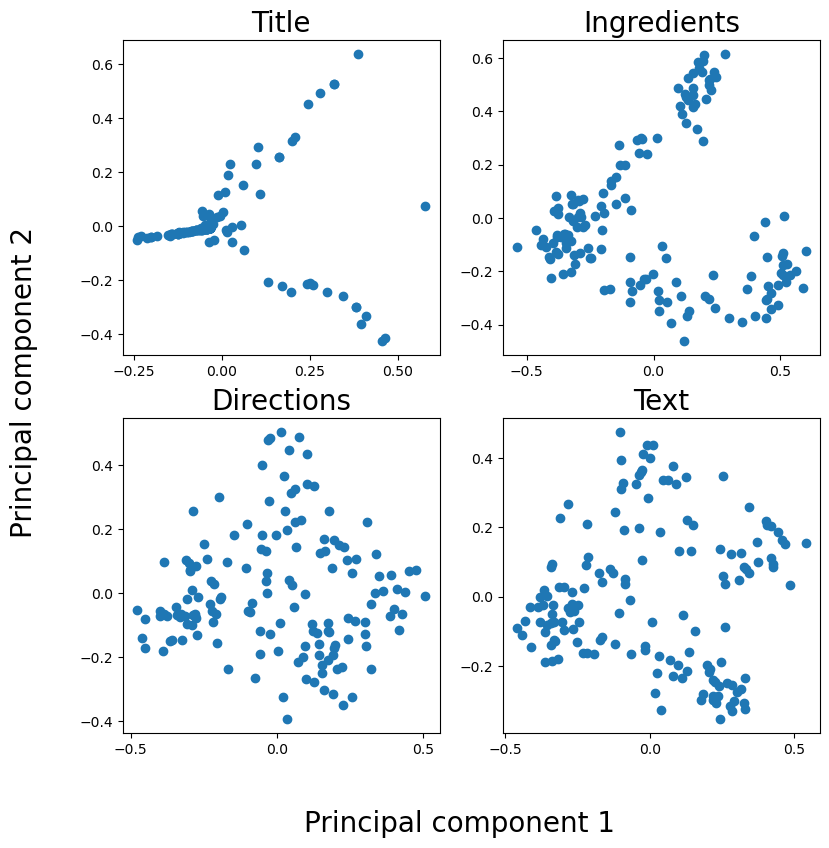

In [31]:
visualize_projection(df_recipes, projection_method="pca")

I also project the data with t-SNE as it is usually better at grouping high-dimensional vectors projected on a 2d plot. By tuning the perplexity parameter, it gives slightly better results than PCA.


/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change

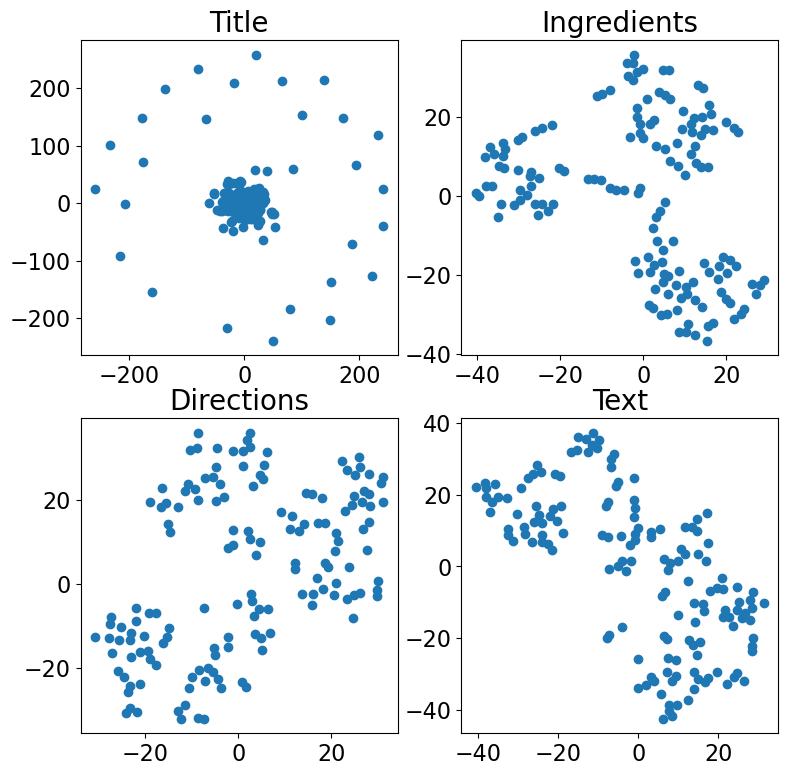

In [32]:
visualize_projection(df_recipes, projection_method="tsne")

The "ingredients" section projected with t-SNE seems to produce the cleanest groupings, so I visualize it interactively with bokeh. On hovering a point, the associated recipe's name is shown, allowing me to gain insight into the meaning of each of the groups.

In [33]:
visualize_projection_interactive("ingredients", df_recipes, projection_method="tsne")

/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


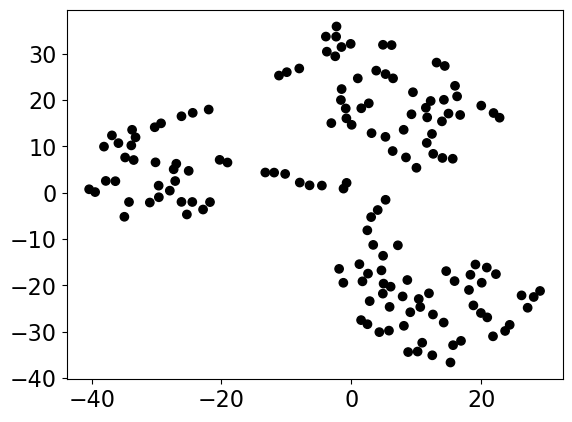

In [34]:
visualize_projection_single("ingredients", df_recipes, projection_method="tsne")

We can see 3 clusters of points:
- the top one contains exclusively salty meals, in particular most of the Spanish ones
- the one on the left contains desserts such as tiramisu and pie, as well as some main dishes containing some crust or dough (mignon fillet in crust, salmon croissants, quiche) towards the bottom of the cluster
- the one on the right also contains sweet recipes, as well as a few salty ones (in particular chicken)

## Clustering

Based on the above observations, I expect to be able to cluster the recipes into 2 large groups: sweet (desserts and snacks) and salty (entrées, main dishes). I also try to do a finer clustering (with for example 4 clusters which might be desserts, snacks, meat and vegetables).

I attempt 3 different methods to group the recipes:
- K-means clustering
- DBSCAN as it should be able to better detect non-convex clusters while ignoring the 'outlier' recipes
- Latent Dirichlet Allocation (LDA)

### K-means clustering

#### Salty/sweet

Here I run K-means clustering with 2 clusters only on the ingredients section as it looks the most promising.

In [35]:
clusters = get_clusters("ingredients", df_recipes, 2)
visualize_projection_interactive("ingredients", df_recipes, projection_method="tsne", clusters=clusters)

/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


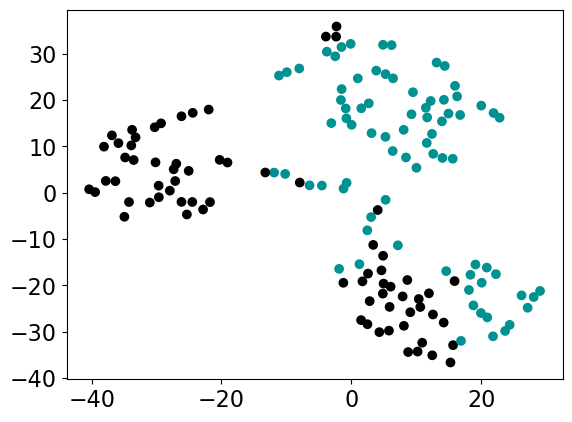

In [36]:
visualize_projection_single("ingredients", df_recipes, projection_method="tsne", clusters=clusters)

As envisioned, the algorithm has been able to separate well between salty dishes (in blue) and sweet ones (in black). There are just a few misclassifications, mostly salty dishes with crust (such as quiche and empanadas) being grouped as sweet dishes.

Next, I try to run the same clustering but using the whole text. The results are not as good so in the following approaches I will focus only on the ingredients section.

In [37]:
clusters = get_clusters("text", df_recipes, 2)
visualize_projection_interactive("text", df_recipes, projection_method="tsne", clusters=clusters)

/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


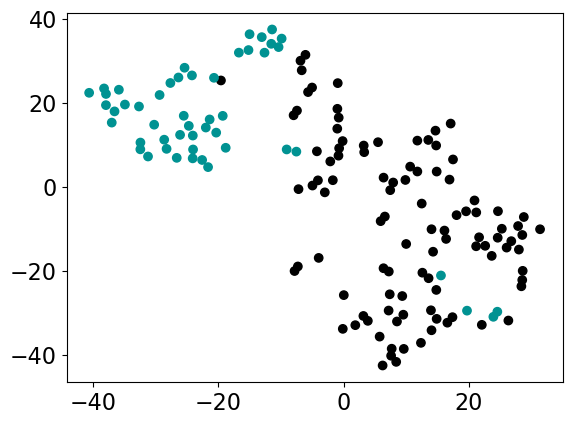

In [38]:
visualize_projection_single("text", df_recipes, projection_method="tsne", clusters=clusters)

#### Finer clustering

I now try to run K-means with more clusters.

In [39]:
clusters = get_clusters("ingredients", df_recipes, 3)
visualize_projection_interactive("ingredients", df_recipes, projection_method="tsne", clusters=clusters)

/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


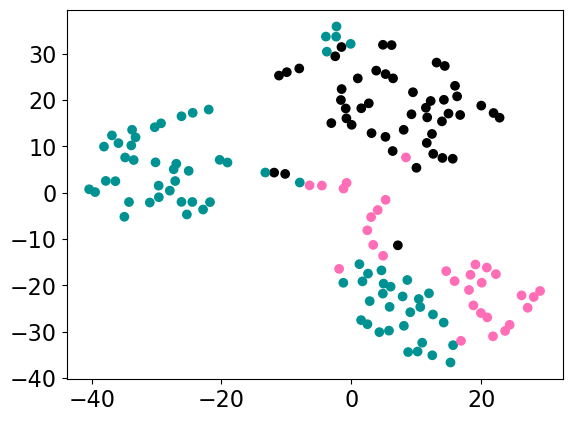

In [40]:
visualize_projection_single("ingredients", df_recipes, projection_method="tsne", clusters=clusters)

Above, with 3 clusters we now observe:
- sweet dishes in blue same as before
- in pink salty dishes, mostly meat
- in black the rest of the salty dishes, including almost all the Spanish ones

In [41]:
clusters = get_clusters("ingredients", df_recipes, 4)
visualize_projection_interactive("ingredients", df_recipes, projection_method="tsne", clusters=clusters)

/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


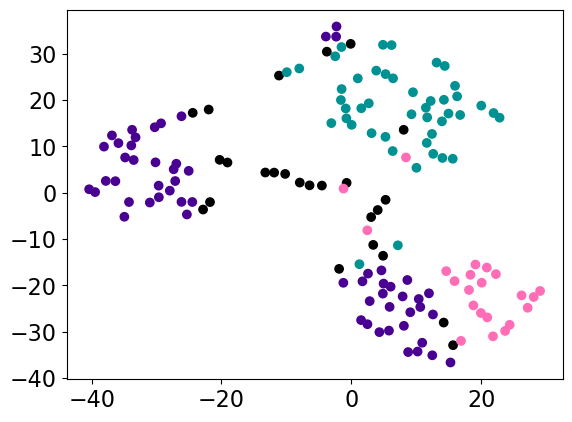

In [42]:
visualize_projection_single("ingredients", df_recipes, projection_method="tsne", clusters=clusters)

Above, using 4 clusters doesn't add much as it simply splits the sweet recipes into two.

In [43]:
clusters = get_clusters("ingredients", df_recipes, 5)
visualize_projection_interactive("ingredients", df_recipes, projection_method="tsne", clusters=clusters)

/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


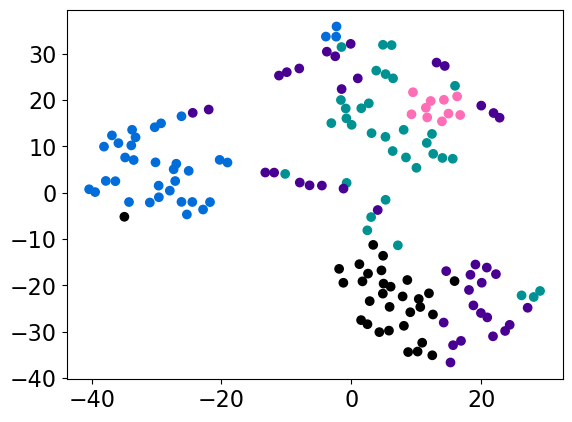

In [44]:
visualize_projection_single("ingredients", df_recipes, projection_method="tsne", clusters=clusters)

Same thing for 5 clusters which now arbitrarily separates one of the salty dishes cluster.

Thus, with K-means, the best results are obtained by using only 2 clusters to separate well between salty and sweet dishes. Using 3 clusters might also be interesting to separate between sweet, meat and Spanish dishes.

### DBSCAN

To get an idea for DBSCAN's eps parameter, I first compute the average distance between points within K-means clusters. I then do a bit more hand-tuning and arrive at eps=10 and min_samples=20 as a result.

In [45]:
# tf-idf on ingredients
vectorizer = TfidfVectorizer()
response = vectorizer.fit_transform(df_recipes[f"preprocessed_ingredients"])
X = response.toarray()

# standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# compute average distance between points within K-means clusters to get an idea for DBSCAN's epsilon parameter
kmeans_clusters = get_clusters("ingredients", df_recipes, 2)
print(
    f"Average distance between points within 1st K-means cluster: {pdist(X_scaled[kmeans_clusters == 0], 'euclidean').mean()}")
print(
    f"Average distance between points within 2nd K-means cluster: {pdist(X_scaled[kmeans_clusters == 1], 'euclidean').mean()}")

Average distance between points within 1st K-means cluster: 11.704295382427546
Average distance between points within 2nd K-means cluster: 14.374630778689562


In [46]:
clusters = get_clusters("ingredients", df_recipes, clustering_method="dbscan", eps=10, min_samples=20)
visualize_projection_interactive("ingredients", df_recipes, projection_method="tsne", clusters=clusters)

/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/thomas/miniconda3/envs/dathena-exo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


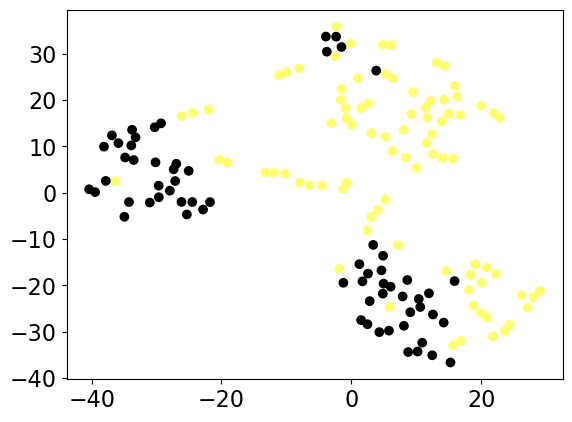

In [47]:
visualize_projection_single("ingredients", df_recipes, projection_method="tsne", clusters=clusters)

Above we observe that by using DBSCAN with roughly tuned eps and min_samples we get a similar result as with K-means clustering with 2 clusters. Although the points corresponding to salty dishes with crust are no longer misclassified as sweet dishes, a few of the sweet dishes (cake, crumble) are now classified as salty. So there has been no major improvement compared to K-means clustering.

### LDA

As an alternative to clustering algorithms, I also try out LDA.

In [48]:
data_words = [[w for w in l.split()] for l in df_recipes[f'preprocessed_ingredients'].to_list()]
id2word = corpora.Dictionary(data_words)
corpus = [id2word.doc2bow(text) for text in data_words]

In [49]:
def flatten(l):
    return [item for sublist in l for item in sublist]

I do grid search to look for the best values for the num_topics, alpha and eta parameters of LDA. I use the product of topic coherence and topic diversity as a metric to compare different models.

In [51]:
# grid search to optimize LDA parameters
nums_topics = range(2, 6)
alphas = ['symmetric', 'asymmetric', 'auto'] + [10 ** k for k in range(-4, 2)]
etas = ['symmetric', 'auto'] + [10 ** k for k in range(-1, 3)]

best_score = 0
# try all different combinations of num_topics, alpha and eta
for n in nums_topics:
    for a in alphas:
        for e in etas:
            scores = []
            cohs = []
            divs = []
            for _ in range(
                    5):  # for each combination of parameters, run LDA 5 times and compute average score to account for randomness
                lda_model = LdaModel(corpus=corpus,
                                     id2word=id2word,
                                     num_topics=n, alpha=a, eta=e)
                cm = CoherenceModel(model=lda_model, corpus=corpus, texts=data_words,
                                    coherence='c_v')  # topic coherence measures how coherent with each other the words in each topic are
                coherence = cm.get_coherence()
                diversity = len(set([t[0] for t in flatten(
                    [t[1] for t in lda_model.show_topics(num_words=10, formatted=False)])])) / (
                                    10 * n)  # topic diversity measures how much the topics don't overlap
                score = coherence * diversity  # optimize the product of topic coherence and topic diversity to find the best model
                scores.append(score)
                divs.append(diversity)
                cohs.append(coherence)
            sc = np.array(scores).mean()
            if sc > best_score:  # look for model with best score
                best_score = sc
                print(
                    f"Avg score={sc:.2f}, avg coh={np.array(cohs).mean():.2f}, avg div={np.array(divs).mean():.2f} -- {n} topics, alpha={a}, eta={e}")

Avg score=0.25, avg coh=0.36, avg div=0.71 -- 2 topics, alpha=symmetric, eta=symmetric
Avg score=0.27, avg coh=0.36, avg div=0.75 -- 2 topics, alpha=symmetric, eta=auto
Avg score=0.27, avg coh=0.37, avg div=0.73 -- 2 topics, alpha=symmetric, eta=1
Avg score=0.28, avg coh=0.37, avg div=0.76 -- 2 topics, alpha=asymmetric, eta=symmetric
Avg score=0.28, avg coh=0.38, avg div=0.74 -- 2 topics, alpha=asymmetric, eta=auto
Avg score=0.29, avg coh=0.39, avg div=0.73 -- 2 topics, alpha=asymmetric, eta=100
Avg score=0.29, avg coh=0.36, avg div=0.79 -- 2 topics, alpha=0.001, eta=symmetric
Avg score=0.33, avg coh=0.41, avg div=0.80 -- 2 topics, alpha=0.001, eta=auto


The best model found has a quite bad score and has 2 topics, alpha=0.001 and eta=auto.

In [56]:
best_lda_model = LdaModel(corpus=corpus,
                          id2word=id2word,
                          num_topics=2, alpha=0.001, eta="auto")

In [57]:
best_lda_model.show_topics()

[(0,
  '0.067*"cup" + 0.048*"teaspoon" + 0.040*"flour" + 0.035*"egg" + 0.034*"taste" + 0.032*"oil" + 0.029*"sugar" + 0.028*"white" + 0.028*"pepper" + 0.025*"gram"'),
 (1,
  '0.090*"cup" + 0.044*"teaspoon" + 0.043*"tablespoon" + 0.038*"sugar" + 0.033*"pepper" + 0.030*"butter" + 0.027*"white" + 0.027*"garlic" + 0.027*"oil" + 0.025*"egg"')]

In [58]:
dominant_topics = []
for row in best_lda_model[corpus]:
    row = sorted(row, key=lambda x: x[1], reverse=True)
    dominant_topics.append(row[0][0])
dominant_topics = np.array(dominant_topics, dtype=bool)

In [59]:
print(f"Recipes in topic 1: {np.array(df_recipes[f'translated_title'].tolist())[dominant_topics == 0]}")
print("\n")
print(f"Recipes in topic 2: {np.array(df_recipes[f'translated_title'].tolist())[dominant_topics == 1]}")

Recipes in topic 1: ['Spicy Gluten-Free Chicken and Cheddar Waffles with Blackberry-Maple Syrup'
 'Best Ever Muffins' 'Quick and Easy Pancit' 'Easy Rib Eye Roast'
 'Pesto Pasta with Chicken' 'Doggie Birthday Cake' 'Stuffed Green Peppers'
 'Sweet Jalapeño Cornbread' 'Parmesan Crusted Chicken'
 'Homemade Banana Pudding' 'Almost No Fat Banana Bread' 'Scorpion Bowl'
 'Spaghetti Sauce' "My Grandmother's Potato Chip Cookies"
 'Veal blanquette: traditional recipe' 'Mignon fillet in crust'
 'Chocolate melting ramekins' 'Gingerbread'
 'Ultra-fast sponge cake and yet so aerial ...' 'Sautéed veal at Chorizo'
 'Chocolate cake for schoolchildren' 'Easy apple cake'
 'Easy and quick pancakes' 'Salt cake with ham and olives'
 'Quich free pasta' 'Fast melting chocolate cake' 'Easy house blinis'
 'Machine Parmentier' 'Custard' 'Chocolate cake and powdered almonds'
 'Yogurt cake' 'Simple crumble' 'Pancake dough (most refined)'
 'Bordeaux canelles' 'Chicken with mustard, dragon herb and mushrooms'
 'Tende

We can observe that the 2 topics found are not well balanced and do not split salty and sweet recipes well. Perhaps with some more tuning the results could improve.